In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 10, 7
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150
%matplotlib inline

from astropy import constants as const
from astropy.modeling import models, fitting

import emcee
import corner

import astroML 
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=14, usetex=True)

import scipy 
import scipy.signal as sig
from scipy.signal import medfilt
import scipy.optimize as op
import transit
import re

/Users/mbadenas/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Peak Detection

In [2]:
#Credits: https://blog.ytotech.com/2015/11/01/findpeaks-in-python/
    
def detect_peaks(x, mph=None, mpd=1, threshold=0, edge='rising', 
                 kpsh=False, valley=False, show=False, ax=None):
    
    x = np.atleast_1d(x).astype('float64')
    if x.size < 3: return np.array([], dtype=int)
    if valley: x = -x
    
    dx = x[1:] - x[:-1] # find indices of all peaks
    indnan = np.where(np.isnan(x))[0] # handle NaN's

    if indnan.size:
        x[indnan] = np.inf
        dx[np.where(np.isnan(dx))[0]] = np.inf
        
    ine, ire, ife = np.array([[], [], []], dtype=int)
    
    if not edge:
        ine = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) > 0))[0]
    else:
        if edge.lower() in ['rising', 'both']:
            ire = np.where((np.hstack((dx, 0)) <= 0) & (np.hstack((0, dx)) > 0))[0]
        if edge.lower() in ['falling', 'both']:
            ife = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) >= 0))[0]
    ind = np.unique(np.hstack((ine, ire, ife)))
    
    # handle NaN's
    if ind.size and indnan.size:
        # NaN's and values close to NaN's cannot be peaks
        ind = ind[np.in1d(ind, np.unique(np.hstack((indnan, indnan-1, indnan+1))), invert=True)]
    
    # first and last values of x cannot be peaks
    if ind.size and ind[0] == 0:
        ind = ind[1:]
    if ind.size and ind[-1] == x.size-1:
        ind = ind[:-1]
    
    # remove peaks < minimum peak height
    if ind.size and mph is not None:
        ind = ind[x[ind] >= mph]
    
    # remove peaks - neighbors < threshold
    if ind.size and threshold > 0:
        dx = np.min(np.vstack([x[ind]-x[ind-1], x[ind]-x[ind+1]]), axis=0)
        ind = np.delete(ind, np.where(dx < threshold)[0])
    
    # detect small peaks closer than minimum peak distance
    if ind.size and mpd > 1:
        ind = ind[np.argsort(x[ind])][::-1]  # sort ind by peak height
        idel = np.zeros(ind.size, dtype=bool)
        for i in range(ind.size):
            if not idel[i]:
                # keep peaks with the same height if kpsh is True
                idel = idel | (ind >= ind[i] - mpd) & (ind <= ind[i] + mpd) \
                    & (x[ind[i]] > x[ind] if kpsh else True)
                idel[i] = 0  # Keep current peak
        # remove the small peaks and sort back the indices by their occurrence
        ind = np.sort(ind[~idel])

    if show:
        if indnan.size: x[indnan] = np.nan
        if valley: x = -x
        plot_peaks(x, mph, mpd, threshold, edge, valley, ax, ind)

    return ind

In [3]:
def plot_peaks(x, mph, mpd, threshold, edge, valley, ax, ind):
    """Plot results of the detect_peaks function."""
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(10, 6))

    ax.plot(x, '.', lw=1)
    if ind.size:
        label = r'valley' if valley else 'peak'
        label = label + 's' if ind.size > 1 else label

        ax.plot(ind, x[ind], '.', mfc=None, mec='r', mew=2, ms=7,
                label='%d %s' % (ind.size, label))
        
        ax.legend(loc = 'best', framealpha=.5, numpoints=1)
        ax.set_xlim(-.02*x.size, x.size*1.02-1)
        ymin, ymax = x[np.isfinite(x)].min(), x[np.isfinite(x)].max()
        yrange = ymax - ymin if ymax > ymin else 1
        
        ax.set_ylim(ymin - 0.1*yrange, ymax + 0.1*yrange)
        ax.set_xlabel(r'Position in the array', fontsize=14)
        ax.set_ylabel(r'Amplitude', fontsize=14)
        mode = r'Valley detection' if valley else 'Peak detection'
        ax.set_title("%s (mph=%s, mpd=%d, threshold=%s, edge='%s')"
                     % (mode, str(mph), mpd, str(threshold), edge))
        # plt.grid()
        plt.show()

In [4]:
filename = 'KID5972334.txt'
target_id = int(re.findall(r'\d+', filename)[0])

complete_sample = pd.read_csv('all_targets_P15to15point5.csv', sep=',', comment='#')
for row in complete_sample.itertuples(index = True, name='Pandas'):
    kepid = getattr(row, "kepid")
    if kepid == target_id:
        rs = getattr(row, "koi_srad") #solar radii
        rs_errPos = getattr(row, "koi_srad_err1"); rs_errNeg = getattr(row, "koi_srad_err2")
        rs_err = np.abs((rs_errPos+rs_errNeg)/2.)
        smass = getattr(row, "koi_smass") #solar mass
        smass_errPos = getattr(row, "koi_smass_err1"); smass_errNeg = getattr(row, "koi_smass_err2")
        smass_err = np.abs((smass_errPos+smass_errNeg)/2.)
        rp = getattr(row, "koi_prad") # in Earth radii
        rp_solarRad = getattr(row, "koi_prad")*0.009168 # in solar radii
        srho = getattr(row, "koi_srho")  #g/cm3
        slogg = getattr(row, "koi_slogg") # Stellar Surface Gravity [log10(cm/s**2)]  
        sma = getattr(row, "koi_sma")  #Orbit Semi-Major Axis [AU]
        sma_solarRad = sma*215
        P = getattr(row, "koi_period") # Orbital Period [days]
        depth = getattr(row, "koi_depth") #parts per million
        b = getattr(row, "koi_impact")
        u1 = getattr(row, "koi_ldm_coeff1");
        u2 = getattr(row, "koi_ldm_coeff2")
        num_planets = getattr(row, "koi_count")
        inc = getattr(row,"koi_incl") #in degrees
        dor = getattr(row,"koi_dor") #Planet-Star Distance over Star Radius
        
print('rho={0:0.3f}, logg={1:0.3f} [log10(cm/s**2)], a={2:0.3f} [AU]'.format(srho, slogg,sma))

rho=1.851, logg=4.484 [log10(cm/s**2)], a=0.116 [AU]


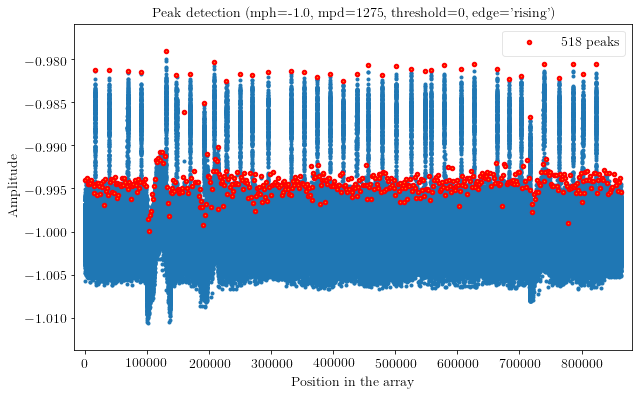

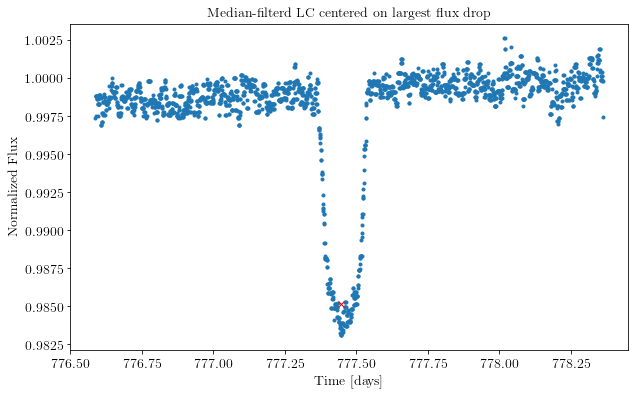

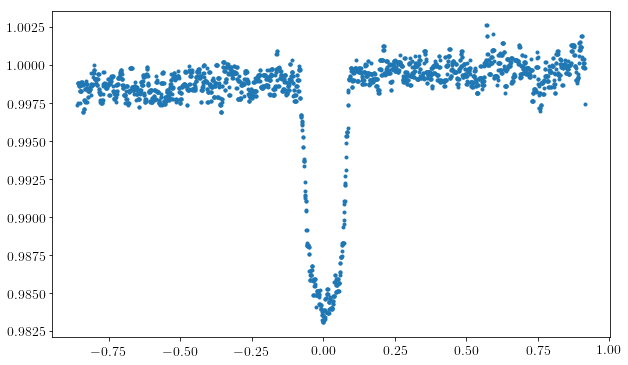

In [5]:
#KID5792202 = 5 planets

df = pd.read_csv(filename,sep='\t',index_col=None)
df.columns = ["time","flux","flux_err"]

x = df["time"]; 
y = df["flux"];
yerr = df["flux_err"]

total_days = x.iloc[-1]-x.iloc[0]
one_day = int(len(x)/total_days) # len(x)/total_days corresponds to 1 day 

ind = detect_peaks(y*-1, mph=-1., mpd=one_day, show=True) #mpd: detect peaks that are at least separated by min peak distance (in number of data)
flux_peaks = y[ind]
time_max_peak = (flux_peaks).idxmin(axis=None, skipna=True)
dist_from_transit = int(one_day/1.)

#y = sig.medfilt(y,13)

newX = (x[time_max_peak-dist_from_transit:time_max_peak+dist_from_transit]).values
newY = (y[time_max_peak-dist_from_transit:time_max_peak+dist_from_transit]).values
newY_err = (yerr[time_max_peak-dist_from_transit:time_max_peak+dist_from_transit]).values

time_max_peak = np.argmin(sig.medfilt(newY,13))
tc = newX[time_max_peak]

plt.figure(figsize=(10,6))
plt.plot(newX, sig.medfilt(newY,9), ".",tc, newY[time_max_peak],'xr'); 
plt.title('Median-filterd LC centered on largest flux drop')
plt.ylabel("Normalized Flux"); plt.xlabel("Time [days]")

# Subtract time offset
newX-=tc
plt.figure(figsize=(10,6))
plt.plot(newX, sig.medfilt(newY,9), ".") 
np.savetxt('example_foldedLC.txt', np.transpose([newX, newY]), fmt='%.3f', delimiter=' ')

# Transit Routine (DFM)

A Python library for generating light curves of transiting planets.

In [6]:
def lnlike(theta, timeLC, fluxLC, errorLC, allfixed):
    """
    Calculates the log of the likelihood of the transit model being the right model given the following parameters:
    theta[0] = pdepth = (Rp/Rs)^2
    theta[1] = pb = the mean impact parameter, measured in stellar radii (not Solar radii). See documentation.
    theta[2] = sigma = an additional white noise term
    theta[3] = u1 + u2 = sum of LD coefficients
    theta[4] = pmass = the mass of the star (controlled via gaussian prior)
    theta[5] = pradius = the radius of the star (controlled via gaussian prior)
    theta[6] = f0 = the out of eclipse flux
    theta[7] = orbital period 
    """
    ecc, mass, masserr, radius, radiuserr, diffLD, tKep = allfixed
    pdepth, pb, sigma, sumLD, pmass, pradius, f0, pperiod, ptc = theta 
    
    #Note: pmass and prad (stellar mass and radius) controlled via gaussian prior. By letting M* and R* be free parameters in the model, we allow the stellar density to fluctuate. 
    
    u1 = 0.5*(sumLD+diffLD)
    u2 = sumLD-u1
    s = transit.System(transit.Central(mu1=u1, mu2=u2, mass = pmass, radius = pradius, dilution=0.0))
    body = transit.Body(radius=np.sqrt(pdepth)*pradius, period=pperiod, t0=ptc, b=np.abs(pb), e=ecc)
    s.add_body(body)
    inv_sigma2 = 1.0/(errorLC**2 + sigma**2)
    ftheo = s.light_curve(timeLC, texp=tKep, tol=1e-08, maxdepth=4)
    ftheo = ftheo-1+f0
    return -0.5*(np.sum((fluxLC-ftheo)**2*inv_sigma2 - np.log(inv_sigma2)) + ((pmass-mass)/masserr)**2
            + ((pradius-radius)/radiuserr)**2)

def lnprior(theta):
    ##https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations
    pdepth, pb, sigma, sumLD, pmass, pradius, f0, pperiod, ptc = theta
    if ((0.3 < sumLD < 1.0) and (0 <= pb < 1) and (0 <= sigma) and 
    (pradius > 0) and (pdepth > 0.0) and (pmass > 0.0) and
        (13.5 <= pperiod < 500)) and (-1.0 < ptc < 1.0):
        return 0.0
    return -np.inf    
    
def lnprob(theta, timeLC, fluxLC, errorLC, allfixed):
    ecc, mass, masserr, radius, radiuserr, diffLD, tKep = allfixed
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, timeLC, fluxLC, errorLC, allfixed)

In [7]:
def fit_lc(nl, guesses, lc_data):
    res = op.minimize(nll, guesses, lc_data, options={ 'maxiter': 1e3,'disp': True},method='Nelder-Mead')
    ml_fit = res["x"] #array with: depth_ml, b_ml, sigma_ml, sumLD_ml, mass_ml, radius_ml, f0_ml, period_ml, tc_ml
    return ml_fit

In [8]:
sc = 58.0  #sc = 58 sec
tKep = sc/60/60/24  # sc in days

period_guess = 13.5
ecc = 0.0
t_conj_guess = 0.0
depth_guess = 1 - newY.min()
diffLD = u1 - u2
#sigma_guess = np.std(newY_err)

In [9]:

allfixed = [ecc, smass, smass_err, rs, rs_err, diffLD, tKep]
initial_guesses = [1.2*depth_guess, 0.5, 0.0, u1 + u2, smass, rs, 1.0, period_guess, t_conj_guess]

nll = lambda *args: -lnprob(*args)

params0 = (newX, sig.medfilt(newY, 13), 0.0, allfixed)
res0 = fit_lc(nll, initial_guesses, params0)
res0[2]=0.0
print("\t\t Period (fit 0): {:0.6f} days".format(res0[7]))

params1 = (newX, newY, 0.0, allfixed)
res1 = fit_lc(nll, res0, params1)
res1[2]=0.0
print("\t\t Period (fit 1): {:0.6f} days".format(res1[7]))

params2 = (newX, newY, newY_err, allfixed)
res2 = fit_lc(nll, res1, params2)
depth_ml, b_ml, sigma_ml, sumLD_ml, mass_ml, radius_ml, f0_ml, period_ml, tc_ml = res2
u1_ml = 0.5 * (sumLD_ml + diffLD)
u2_ml = sumLD_ml - u1_ml
print("\t\t Period (fit 2): {:0.6f} days".format(res2[7]))

print("Depth (fit 2): {:0.3f} \nImpact Parameter (fit 2): {:0.3f}".format(depth_ml,b_ml))

/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in subtract


		 Period (fit 0): 13.500047 days
		 Period (fit 1): 14.941102 days
		 Period (fit 2): 15.597611 days
Depth (fit 2): 0.013 
Impact Parameter (fit 2): 0.496


Plot the fit on top of the actual light curve.

/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)


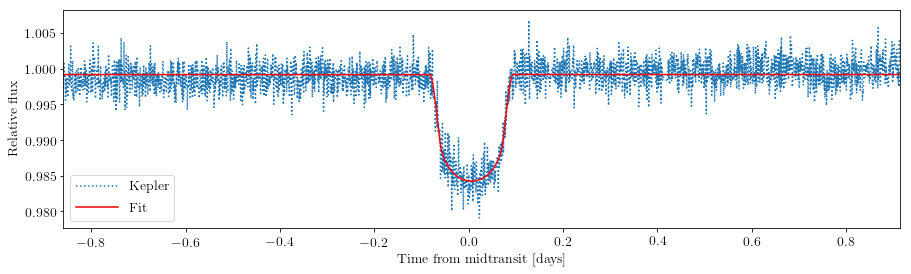

In [10]:
# Compute the theoretical light curve integrated over a Kepler short-cadence exposure time.
s = transit.System(transit.Central(mu1=u1_ml, mu2=u2_ml, mass=mass_ml, radius=radius_ml, dilution=0.0))
body = transit.Body(radius=np.sqrt(depth_ml)*radius_ml,period=period_ml,t0=tc_ml,b=b_ml,e=ecc)
s.add_body(body)
t = np.arange(-1, 1, tKep*0.01)
f = s.light_curve(t, texp=tKep, tol=1e-08, maxdepth=4)
f = f - 1.0 + f0_ml

fig = plt.figure(figsize=(15,4))
plt.plot(newX, newY, linestyle = 'dotted', label = 'Kepler')
plt.plot(t, f, color='r',label = 'Fit')
plt.xlabel('Time from midtransit [days]')
plt.ylabel('Relative flux')
plt.xlim([min(newX),max(newX)]) 
plt.legend()

In [11]:
duration = body.duration #from eq'n 14 in Winn (2010)

In [12]:
print("Period [days]: \n\t Fit: {0:0.4f} \n\tTrue: {1:0.4f}".format(period_ml,P))
print("Impact Parameter \n\t Fit: {0:0.4f} \n\tTrue: {1:0.4f}".format(b_ml,b))
print("Depth [ppm]: \n\t Fit: {0:0.4f} \n\tTrue: {1:0.4f}".format(depth_ml,depth/1e6))

Period [days]: 
	 Fit: 15.5976 
	True: 15.3588
Impact Parameter 
	 Fit: 0.4959 
	True: 0.4870
Depth [ppm]: 
	 Fit: 0.0128 
	True: 0.0146


Initialize the MCMC with the appropiate parameters and initial conditions.

In [13]:
ndim, nwalkers = len(initial_guesses), 100
initMCMC = res2
p0 = [initMCMC*(1+1e-4*np.random.randn(ndim)) for i in range(nwalkers)]

Run the MCMC and store the results

In [14]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(newX, newY, newY_err, allfixed))
print("Running burn-in")
pos, prob, state = sampler.run_mcmc(p0, 300, progress=True);
sampler.reset()
print("Running production")
sampler.run_mcmc(p0, 5000, rstate0 = state, progress=True);
print("Burn-in: Done")
samples = sampler.chain[:, 500:, :].reshape((-1, ndim))
np.savetxt('mcmc_samples.txt', samples)

Running burn-in


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
100%|██████████| 300/300 [01:05<00:00,  4.82it/s]


Running production


100%|██████████| 5000/5000 [42:53<00:00,  4.29it/s]    


Burn-in: Done


Create corner plots showing MCMC results.

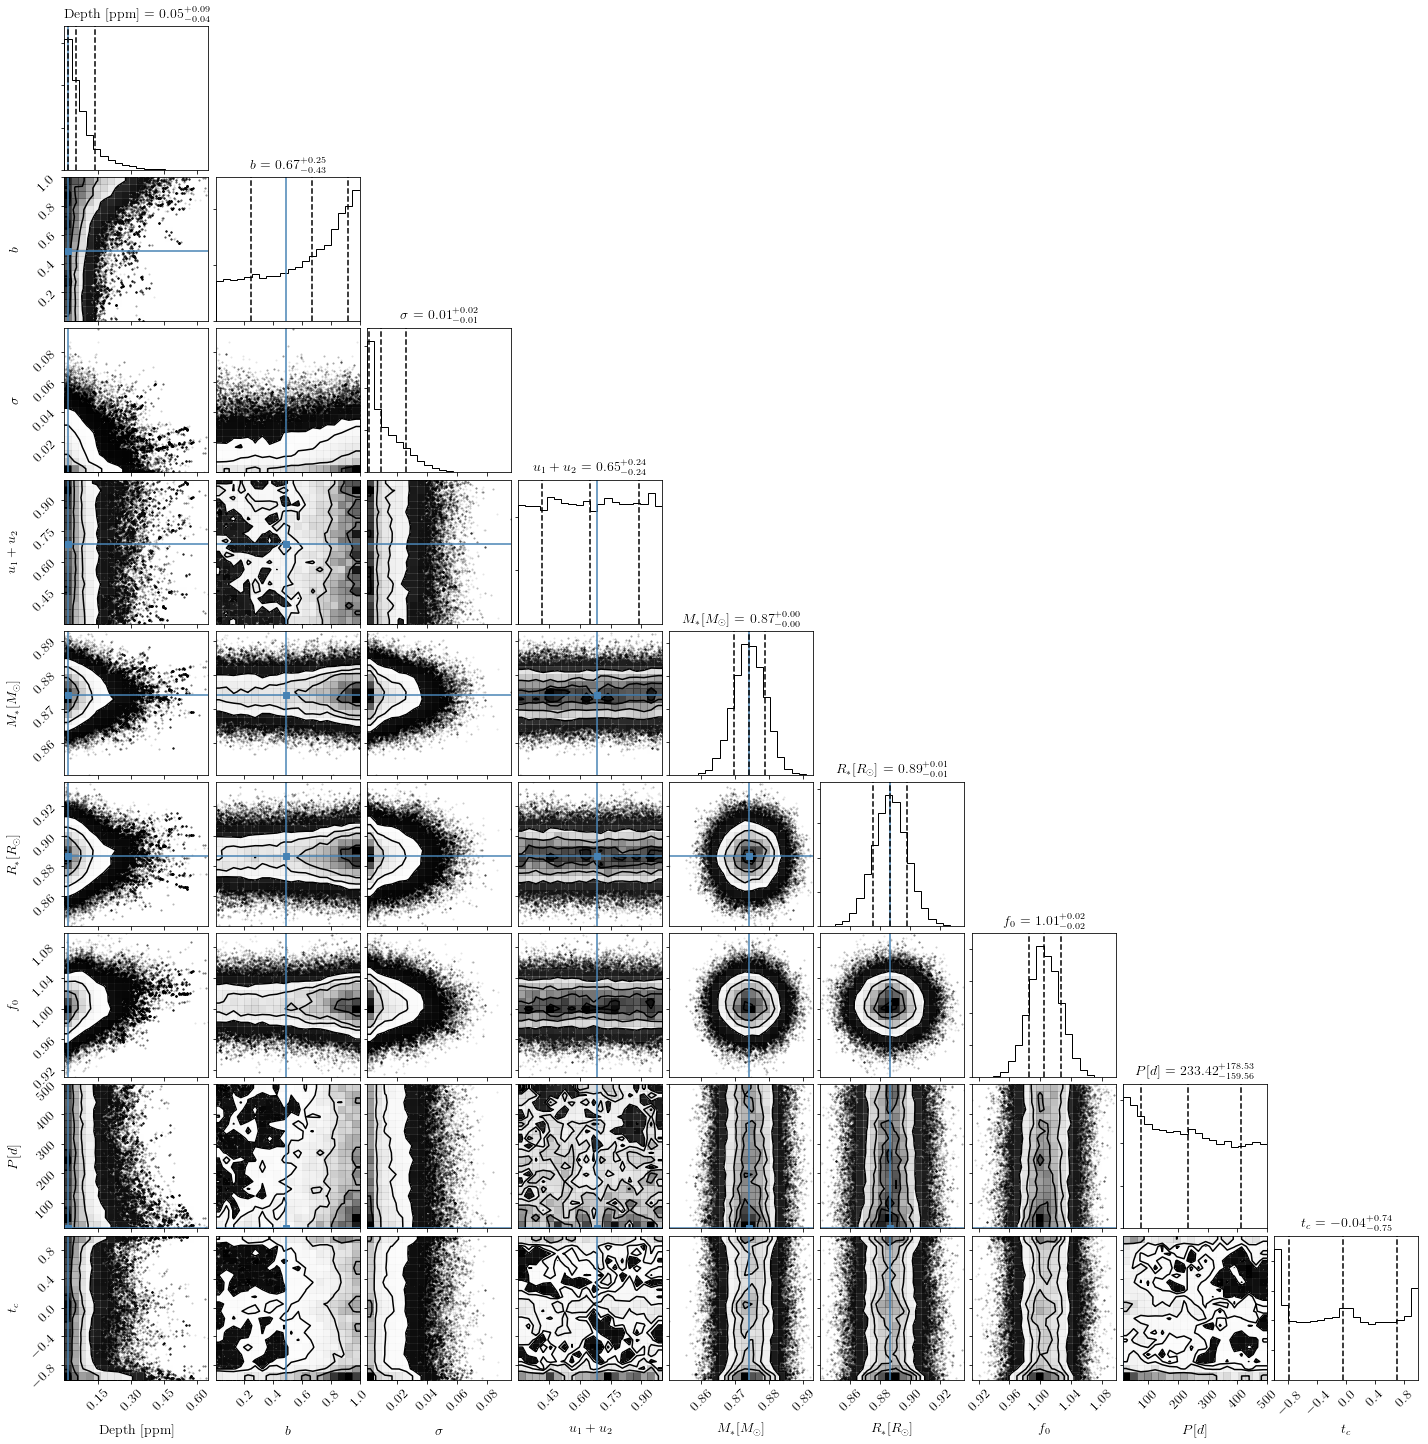

In [15]:
res_labels = ['Depth [ppm]', r'$b$', r'$\sigma$', r'$u_1+u_2$', r'$M_{*} [M_{\odot}]$', 
          r'$R_{*} [R_{\odot}]$', r'$f_{0}$', r'$P [d]$', r'$t_c$']

true_params = [depth/1e6, b, None, u1+u2, smass, rs, None, P, None]

fig = corner.corner(samples, labels=res_labels, 
                    quantiles=[0.16, 0.5, 0.84], truths=true_params, 
                    show_titles=True,title_args={"fontsize": 12}, plot_contours=True)

#show_titles = True -> Title will show the 0.5 quantile, w/ the upper & lower errors given by the quantiles argument.

sampler.acceptance_fraction; #http://eso-python.github.io/ESOPythonTutorials/ESOPythonDemoDay8_MCMC_with_emcee.html

In [ ]:
plt.title('Period Distribution'); plt.xlabel("P [days]")
n, bins, patches = plt.hist(samples[:,7], density = True, weights = None,alpha=0.5) #bins = Edges of the bins

Get the 50% percentile and the +- 1 sigma error interval of the parameters and some derived quantities such as $R_{p}$ and $R_{*}/a$. 

In [ ]:
G = 6.6730e-11

samples[:, 2] = np.exp(samples[:, 2])
planetradsamp = 109.045*np.sqrt(samples[:,0])*samples[:, 5] #in earth rad (rp = sqrt(depth)*rs)
P1 = period_ml*24.0*3600.0 #in sec
r_asamp = ((3.0*np.pi/(G*P1**2))*((samples[:,5]**3/samples[:, 4])/1408.0))**0.3333


depth_mcmc, b_mcmc, sigma_mcmc, sumLD_mcmc, smass_mcmc, rs_mcmc, \
f0_mcmc, period_mcmc, tc_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), 
                           zip(*np.percentile(samples, [15.86, 50, 84.14], axis=0)))

print("MCMC Period [d]:",period_mcmc)
v = np.percentile(planetradsamp, [15.86, 50, 84.14], axis=0)
planetrad_mcmc =(v[1], v[2]-v[1], v[1]-v[0])

v = np.percentile(r_asamp, [15.86, 50, 84.14], axis=0)
r_a_mcmc =(v[1], v[2]-v[1], v[1]-v[0])

In [ ]:
print("\nDepth:\n\tTrue = {:0.3f}".format(depth/1e6))
print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(depth_mcmc[0],depth_mcmc[1],depth_mcmc[2]))

print("\nImpact parameter:\n\tTrue = {:0.3f}".format(b))
print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(b_mcmc[0],b_mcmc[1],b_mcmc[2]))

print("\nPlanet radius [REarth]:\n\tTrue = {:0.3f}".format(rp))
print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(planetrad_mcmc[0],planetrad_mcmc[1],planetrad_mcmc[2]))

print("\nStellar mass [Msun]:\n\tTrue = {:0.3f}".format(smass))
print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(smass_mcmc[0],smass_mcmc[1],smass_mcmc[2]))

print("\nStellar radius [Rsun]:\n\tTrue = {:0.3f}".format(rs))
print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(rs_mcmc[0],rs_mcmc[1],rs_mcmc[2]))

print("\nPeriod [d]:\n\tTrue = {:0.3f}".format(P))
print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(period_mcmc[0],period_mcmc[1],period_mcmc[2]))

print("\nInverse of scaled semi-major axis:\n\tTrue = {:0.4f}".format(1/dor))
print("\tMCMC Fit = {0:0.4f} (+{1:0.4f},-{2:0.4f})".format(r_a_mcmc[0],r_a_mcmc[1],r_a_mcmc[2]))

Plot the  light curve with the MCMC fit. 

In [ ]:
u1_mcmc = 0.5 * (sumLD_mcmc[0] + diffLD)
u2_mcmc = sumLD_mcmc[0] - u1_mcmc
print(u1_mcmc, u2_mcmc)

s = transit.System(transit.Central(mu1=u1_mcmc, mu2=u2_mcmc, mass=smass_mcmc[0], radius=rs_mcmc[0]))
body = transit.Body(radius=np.sqrt(depth_mcmc[0])*rs_mcmc[0],period=period_mcmc[0],t0=0.0,b=b_mcmc[0],e=0.0)

s.add_body(body)
t = np.arange(-1, 1, tKep * 0.01)
f = s.light_curve(t, texp=tKep, tol=1e-08, maxdepth=4)
f = f - 1.0 + f0_mcmc[0]

plt.plot(newX, newY, '.', label = 'kepler')
plt.plot(t, f, label = 'fit')
plt.xlim([min(t),max(t)]) 

# Rough estimations

In [ ]:
def get_keyTimes(times, pre, post, offset, drop, ind_maxPeak):
    y1 = np.abs(pre-offset+0.35*drop)
    y2 = np.abs(pre-offset+0.65*drop)
    y3 = np.abs(post-offset+0.65*drop)
    y4 = np.abs(post-offset+0.35*drop)
    
    margin = 20
    res1 = times[np.argmin(y1)]
    res2 = times[np.argmin(y2)+margin]
    res3 = times[np.argmin(y3)+ind_maxPeak-margin]
    res4 = times[np.argmin(y4)+ind_maxPeak]
    
    return res1, res2, res3, res4

In [ ]:
baseline = np.median(newY)
delta = np.median(newY)-newY[time_max_peak]

pre_tr = newY[:time_max_peak]
post_tr = newY[time_max_peak:]

t1,t2,t3,t4 = get_keyTimes(newX, pre_tr, post_tr, baseline, delta, time_max_peak)

print("t1 = {0:0.2f} days | t2 = {1:0.2f} days | t3 = {2:0.2f} days | t4 = {3:0.2f}".format(t1,t2,t3,t4))

xposition = [t1,t2,t3,t4]
plt.figure(figsize=(10,6))
plt.plot(newX, newY, ".",tc, newY[time_max_peak],'o')
plt.ylabel("Flux"); plt.xlabel("Time [days]")
for xc in xposition: plt.axvline(x=xc, color='r', linestyle='dotted')

In [ ]:
tc = (((t3+t2)/2)+((t4+t1)/2))/2
width_trans = t3-t2
slope_trans = -delta/(t2-t1)
T = ((t4+t3)-(t2+t1))/2 #FWHM 
tau_avg = ((t2-t1)+(t4-t3))/2

print(tc,(t3+t2)/2, (t4+t1)/2)

In [ ]:
t_init = models.Trapezoid1D(amplitude=-delta, x_0=tc, width=width_trans, slope=slope_trans)
                           #fixed={'amplitude': True})
g_init = models.Gaussian1D(amplitude=-delta, mean=tc, stddev=T)
l_init = models.Lorentz1D(amplitude=-delta, x_0=tc, fwhm = T) 

fit_flux = fitting.LevMarLSQFitter()

t = fit_flux(t_init, newX, newY-baseline)
g = fit_flux(g_init, newX, newY-baseline)
l = fit_flux(l_init, newX, newY-baseline)

#Plot the data with the best-fit model
plt.figure(figsize=(8,5))
plt.plot(newX, newY, '.')
plt.plot(newX, t(newX)+baseline, label='Trapezoid')
plt.plot(newX, g(newX)+baseline, label='Gaussian')
plt.plot(newX, l(newX)+baseline, label='Lorentz')
plt.ylabel("Normalized Flux"); plt.xlabel("Time [days]")
plt.legend()

In [ ]:
##THIS IS ONLY FOR TRAPEZOID MODEL
amp_fit, x0_fit, width_fit, slope_fit = t.parameters

delta_fit = amp_fit*-1
tc_fit = x0_fit

t1_fit = (delta_fit/slope_fit)+t2
t2_fit = (2.*tc_fit-width_fit)/2.
t3_fit = (2.*tc_fit+width_fit)/2.
t4_fit = 2*tc_fit-t1_fit

T_fit = ((t4_fit+t3_fit)-(t2_fit+t1_fit))/2 #FWHM 
tau_fit = ((t2_fit-t1_fit)+(t4_fit-t3_fit))/2

print("T = {0:0.2f} days\ntau = {1:0.2f} days\ndelta = {2:0.5f}\nt1 = {3:0.2f} , t2 = {4:0.2f},\\
t3 = {5:0.2f} , t4 = {6:0.2f} [days]".format(T_fit, tau_fit,
                                               delta_fit, t1_fit, t2_fit,
                                               t3_fit,t4_fit))


tfits_position = [t1_fit,t2_fit,t3_fit,t4_fit]
plt.plot(newX, newY, '.')
plt.plot(newX, t(newX)+baseline, '.k', label='Trapezoid')
plt.xlabel('Time [days]'); plt.ylabel('Normalized Flux')
for xc in tfits_position: plt.axvline(x=xc, color='m', linestyle='dotted')

In [ ]:
Q = 7.1
sigmaP_P = np.sqrt(1/Q**2 * (27*T_fit/2*tau_fit))
print(sigmaP_P)

In [ ]:
G = 6.676e-11  #Unit  = m3 / (kg s2)# Newton's constant in $R_\odot^3 M_\odot^{-1} {days}^{-2}$: G = 2945.4625385377644
srho_kgm3 = srho * 1000   #srho is originally given in g/cm3, but we convert it to kg/m3 

In [ ]:
b2_fit = 1-(T_fit*(np.sqrt(delta_fit))/tau_fit)
P_fit = (((G*np.pi**2)/3)*srho_kgm3*(T_fit*tau_fit*86400**2/np.sqrt(delta_fit))**(3/2))/86400#in days
sma_fit = slogg/4.*(T_fit*tau_fit/np.sqrt(delta_fit))

print("b ||\t Fitted: {1:0.3f}, Real: {0:0.3f} ".format(np.sqrt(b2_fit),b))
print("P ||\t Fitted: {0:0.3f}, Real: {1:0.3f} [days]".format(P_fit,P)) 
print("a ||\t Fitted: {0:0.3f}, Real: {1:0.3f} [AU]".format(sma,sma_fit))

## Data Folding

In [ ]:
def fold_data(t,f, tcfit, Pfit, Tfit):
    range_transit = Tfit/2 #[days]
    print("Period (fit): {0:0.3f} days, Transit range: {1:0.3f} days".format(Pfit,range_transit))
    x = (t - tcfit + range_transit*Pfit) % Pfit - range_transit*Pfit
    m = np.abs(x) < 0.5
    tfolded = x[m]
    ffolded = f[m]
    return tfolded, ffolded
    
newX_fold, newY_fold = fold_data(newX, newY, tc_fit, P_fit, T_fit)

plt.plot(newX_fold,newY_fold,'.')
plt.xlabel('Time [days]'); plt.ylabel('Normalized Flux')
plt.title('Folded LC')

In [ ]:
f0 = models.Linear1D(slope = 0.0, intercept = np.median(newY))
gau = models.Gaussian1D(amplitude=-delta, mean=tc, stddev=T)
loren = models.Lorentz1D(amplitude=-delta, x_0=tc, fwhm = T) 
trap = models.Trapezoid1D(amplitude=-delta, x_0=tc, width=t3-t2, slope=-delta/(t2-t1))

# Now to fit the data create a new superposition with initial guesses for the parameters:
LG_init = f0+gau
LL_init = f0+loren
LT_init = f0+trap

fit_flux = fitting.SLSQPLSQFitter()
LG_fit = fit_flux(LG_init, newX, newY);
LL_fit = fit_flux(LL_init, newX, newY);
LT_fit = fit_flux(LT_init, newX, newY);

# Plot the data with the best-fit model
plt.figure(figsize=(8,5))
plt.plot(newX, newY, '.')
plt.plot(newX, LG_fit(newX),label='Linear + Gaussian')
plt.plot(newX, LL_fit(newX),label='Linear + Lorentz')
plt.plot(newX, LT_fit(newX),label='Linear + Trapezoidal')
plt.legend(); plt.xlabel('Time [days]'); plt.ylabel('Flux')

In [ ]:
import emcee
import corner

def lnprior(theta, args):
    minT, maxT = args
    delta, tc, width, slope = theta
    if 0.0 < delta < 0.2 and  (minT < tc < maxT) and (0.0 < width < (maxT-minT)) and (-1<slope<0.0):
        return 0.0
    return -np.inf

def lnprob(theta, x, y, yerr = None):
    minT = min(x)
    maxT = max(x)
    lp = lnprior(theta, (minT, maxT))
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)
    #return lnlike(theta, x, y, yerr)

def lnlike(theta, x, y, yerr = None):
    delta, tc, width, slope = theta
    model = models.Trapezoid1D(amplitude=-delta, x_0=tc, 
                               width=width, slope=slope)
    
    #inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
    return -0.5*(np.sum((y-model(x))**2))

ndim, nwalkers = 4, 100
mc_guess = [delta, tc, t3-t2, -delta/(t2-t1)]

pos = [mc_guess + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, 
                                args=(newX, newY-np.median(newY)))

sampler.run_mcmc(pos, 500);

In [ ]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

fig = corner.corner(samples, 
                    labels=["$delta$", "$tc$", "$width$", "$slope$"])

In [ ]:
import vespa
sample_res = vespa.transit_basic.traptransit_MCMC(newX, newY, dfs=1e-05,
                                     nwalkers=200, nburn=300, niter=1000, 
                                     threads=1, p0=[0.1, 0.1, 3, 0], return_sampler=True, maxslope=30)

In [ ]:
samples2 = sample_res.chain[:, 5:, :].reshape((-1, ndim))
fig = corner.corner(samples2)